In [ ]:
!pip install bs4
!pip install selenium
!pip install ipywidgets
!pip install ipython

!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver


In [3]:
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
import requests
import urllib
import time
import math
import sys

cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument(f'user-agent={user_agent}')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument("--incognito")
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


# Step 1: Webscraping (Booking.com, Agoda, Kayk)

In [471]:
global_checkin_date = '2022-10-12'
global_checkout_date = '2022-10-13'
global_city_name = 'Turku'                  # some website require city id (specified in the url)

**Booking.com Estimated Executable time: 10 Minutes.** It will first iterate through the page and then go to individual hotel page to get address, picture and summary. So It will take some time to finish. 

In [472]:
# Note: Estimated Executable time: 9 Minute


def scrape_booking_dot_com():

    checkin_year = global_checkin_date.split('-')[0]
    checkin_month = global_checkin_date.split('-')[1]
    checkin_monthday = global_checkin_date.split('-')[2]
    checkout_year = global_checkout_date.split('-')[0]
    checkout_month = global_checkout_date.split('-')[1]
    checkout_monthday = global_checkout_date.split('-')[2]


    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36',
    }

    hotel_name_arr = []
    hotel_link_arr = []
    hotel_price_arr = []
    hotel_distance_arr = []
    hotel_stars_arr = []
    hotel_review_score_arr = []
    hotel_address_arr = []
    hotel_summary_arr = []
    hotel_photos_arr = []


    for i in range(0, 3):  #defining offset unti (3-1) * 25 = 50, so item 1 to 75
        offset = i * 25
        url = f'https://www.booking.com/searchresults.html?&ss={global_city_name}&dest_type=city&checkin_year={checkin_year}&checkin_month={checkin_month}&checkin_monthday={checkin_monthday}&checkout_year={checkout_year}&checkout_month={checkout_month}&checkout_monthday={checkout_monthday}&extended_dates_check=0&efdco=1&group_adults=2&group_children=0&no_rooms=1&offset={offset}'
        
        page_source = requests.get(url, headers=headers).text
        soup = BeautifulSoup(page_source, features='html.parser')

        for item in soup.findAll('div', {'data-testid': 'property-card'}):
            try:
                hotel_name_arr.append(item.find('div', {'data-testid': 'title'}).text)
            except:
                hotel_name_arr.append(None)


            try:    
                hotel_link_arr.append(item.find('a', {'data-testid': 'title-link'})['href'])
            except:
                hotel_link_arr.append(None)


            try:
                hotel_price_dollar_text = str(item.find('div', {'data-testid': 'price-and-discounted-price'}).find('span').text)

                numbers = ''
                for i in hotel_price_dollar_text:
                    if(i.isdigit()):
                        numbers+=i

                hotel_price_arr.append(int(numbers))
            except:
                hotel_price_arr.append(None)
            

            try:    
                distance_text = str(item.find('span', {'data-testid': 'distance'}).text)
                distance_texts_split = distance_text.split()

                if distance_texts_split[1] == 'miles':
                    hotel_distance_arr.append(round(float(distance_texts_split[0]) * 1.609, 1))         # converting mile to km
                elif distance_texts_split[1] == 'feet':
                    hotel_distance_arr.append(round(float(distance_texts_split[0]) * 0.0003048, 1))     # converting feet to km
                elif distance_texts_split[1] == 'km':
                    hotel_distance_arr.append(float(distance_texts_split[0]))
                elif distance_texts_split[1] == 'm':
                    hotel_distance_arr.append(round(float(distance_texts_split[0]) / 1000, 1)) 
                else:
                    hotel_distance_arr.append(None)
            except:
                hotel_distance_arr.append(None)


            try:
                if item.find('div', {'data-testid': 'rating-stars'}):
                    hotel_stars_arr.append(len(item.find('div', {'data-testid': 'rating-stars'}).findAll('span')))
                elif item.find('div', {'data-testid': 'rating-squares'}):
                    hotel_stars_arr.append(len(item.find('div', {'data-testid': 'rating-squares'}).findAll('span')))
                else:
                    hotel_stars_arr.append(None)
            except:
                hotel_stars_arr.append(None)


            try:    
                hotel_review_score_arr.append(float(item.find('div', {'data-testid': 'review-score'}).find('div').text))
            except:
                hotel_review_score_arr.append(None)


    # Now traverse through links to get address summary and pictures
    for link in hotel_link_arr: ################
        try:
            driver.get(link)
            time.sleep(2)
            
            page = driver.page_source
            soup = BeautifulSoup(page, features='html.parser')

            try:
                hotel_address_arr.append(str(soup.find('p', {'class': 'address address_clean'}).text).strip().split('\n')[0])
            except:
                hotel_address_arr.append(None)
            
            try:
                hotel_summary_arr.append(str(soup.find('div', {'id': 'property_description_content'}).text).rstrip())
            except:
                hotel_summary_arr.append(None)

            hotel_images_temp = []
            try:
                try:
                    image_tags = soup.find('div', {'class': 'clearfix bh-photo-grid bh-photo-grid--space-down fix-score-hover-opacity'}).findAll('a', {'class' :'bh-photo-grid-item'})
                except:
                    image_tags = soup.find('div', {'class': 'clearfix bh-photo-grid fix-score-hover-opacity'}).findAll('a', {'class' :'bh-photo-grid-item'})

                for image_tag in image_tags:
                    try:
                        if image_tag.find('img')['src']:
                            hotel_images_temp.append(image_tag.find('img')['src'])
                    except:
                        pass
                        
                hotel_photos_arr.append(hotel_images_temp)
            except:
                hotel_photos_arr.append(None)
            
        except:
            hotel_address_arr.append(None)
            hotel_summary_arr.append(None)
            hotel_photos_arr.append(None)

    # for i in range(0, 10):  ############### len(hotel_name_arr)
    #     print(hotel_name_arr[i], ' : ', hotel_photos_arr[i])

    df = pd.DataFrame(data=zip(hotel_name_arr, hotel_price_arr, hotel_stars_arr, hotel_address_arr, hotel_distance_arr, hotel_review_score_arr, hotel_summary_arr, hotel_photos_arr, hotel_link_arr), columns=['name','price (euro)','stars', 'address', 'cc_distance (km)', 'review_score', 'summary', 'photos_link', 'link'])

    return df


df_1 = scrape_booking_dot_com()

Print this for booking dot com data

In [473]:
df_1.head()

,name,price (euro),stars,address,cc_distance (km),review_score,summary,photos_link,link
0,Centro Hotel Turku,133,3.0,"Yliopistonkatu 12 A, 20100 Turku, Finland",0.3,8.3,"\nCentro Hotel Turku is located in Turku, 3 mi...",[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/centro-turku....
1,Laivahostel S/S Bore,80,3.0,"Linnankatu 72, 20100 Turku, Finland",2.6,7.7,"\nDocked in the Aurajoki River in Turku, this ...",[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/laivahostel-b...
2,Hotel Kakola,154,4.0,"14 Kakolankatu, 20100 Turku, Finland",1.3,8.9,\n\nYou're eligible for a Genius discount at H...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/kakola.en-gb....
3,Bed&Breakfast Tuure,70,NaN,"Tuureporinkatu 17 C, 20100 Turku, Finland",0.5,8.1,\nThis B&B is 5 minutes’ walk from Turku’s mai...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/bed-turku.en-...
4,Park Hotel Turku,135,4.0,"Rauhankatu 1, 20100 Turku, Finland",0.5,8.7,\n\nYou're eligible for a Genius discount at P...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/park.en-gb.ht...


**Agoda Estimated Executable time: 8 Minutes**. It will first iterate through the page to fetch link and then go to individual hotel page. So It will take some time to finish.

In [474]:

def fetch_hotel_link(hotel_item):
    
    try:
        hotel_link = 'https://www.agoda.com/' + hotel_item.find('a')['href']
    except:
        hotel_link = None

    return hotel_link


def fetch_hotel_name(hotel_content):
    
    try:
        hotel_name = str(str(hotel_content.find('h1', {'data-selenium': 'hotel-header-name'}).text).replace('(', ',').replace('-', ',').split(',')[0])
    except:
        hotel_name = None

    return hotel_name


def fetch_hotel_price(hotel_content):    

    try:
        hotel_price_text = str(hotel_content.find('div', {'data-element-name': 'cheapest-room-price-property-nav-bar'}).text)

        numbers = ''
        for i in hotel_price_text:
            if(i.isdigit()):
                numbers+=i

        hotel_price = int(numbers)
    except:
        hotel_price = None

    return hotel_price


def fetch_hotel_distance(hotel_content):
    # Idea: as there is no clear value from cc, I fetched all and if Helsinki or old Market visible in the text, took that distance
    accepted_place_name = {'Turku', 'turku', 'turun', 'Turun'}

    try:
        all_distance = hotel_content.findAll('div', {'class': 'NearByLocationBox__ListItem'})
        hotel_distance = None

        for dist in all_distance:
            place_name = str(dist.text).split()[0]
            place_distance = float(str(dist.text).split()[-2])
            place_dist_unit = str(dist.text).split()[-1]

            if place_name in accepted_place_name:
                 if place_dist_unit == 'm':
                     hotel_distance = round(place_distance / 1000, 1)
                 elif place_dist_unit == 'km':
                     hotel_distance = place_distance
                 else:
                     hotel_distance = None
                 
                 break
            else:
                pass
    except:
        hotel_distance = None

    return hotel_distance


def fetch_hotel_stars(hotel_content):
    
    try:
        hotel_stars_text = hotel_content.find('i', {'data-selenium': 'mosaic-hotel-rating'})['class'][1]
        hotel_stars = int(hotel_stars_text.split('-')[-1])

        if hotel_stars > 9:
            hotel_stars = int(hotel_stars/10)
    except:
        hotel_stars = None

    return hotel_stars


def fetch_hotel_review_score(hotel_content):
    try:
        hotel_review_score = float(hotel_content.find('div', {'data-selenium': 'hotel-header-review-score'}).find('h3').text)
    except:
        hotel_review_score = None

    return hotel_review_score


def fetch_hotel_address(hotel_content):
    try:
        hotel_address = hotel_content.find('div', {'class': 'HeaderCerebrum__Location'}).find('span').text
    except:
        hotel_address = None

    return hotel_address


def fetch_hotel_summary(hotel_content):
    try:
        hotel_summary = hotel_content.find('div', {'data-element-name': 'property-short-description'}).find('p').text
    except:
        hotel_summary = None

    return hotel_summary


def fetch_hotel_photos(hotel_content):
    hotel_photos = []

    try:
        hotel_photos_contents = hotel_content.find('div', {'data-element-name': 'hotel-mosaic'}).findAll('img')
        for hotel_photos_content in hotel_photos_contents:
            hotel_photos.append('https:' + hotel_photos_content['src'])
    except:
        hotel_photos = []

    return hotel_photos


def scrape_agoda():

    hotel_name_arr = []
    hotel_link_arr = []
    hotel_price_arr = []
    hotel_distance_arr = []
    hotel_stars_arr = []
    hotel_review_score_arr = []
    hotel_address_arr = []
    hotel_summary_arr = []
    hotel_photos_arr = []

    for i in range(2, 6):       ###### 2 - 6          ## turku_id = 14031, 
        link = f'https://www.agoda.com/search?city=14031&checkIn={global_checkin_date}&rooms=1&currency=EUR&currencyCode=EUR&checkOut={global_checkout_date}&hotelStarRating={i}&isRealUser=true'

        driver.get(link)
        time.sleep(5)

        page = driver.page_source
        soup = BeautifulSoup(page, features='html.parser')
        hotel_items = soup.find('ol', {'class': 'hotel-list-container'}).findAll('li', {'data-selenium': 'hotel-item'})

        for hotel_item in hotel_items:
            hotel_link = fetch_hotel_link(hotel_item)
            hotel_link_arr.append(hotel_link)
    

    # Getting unique list only
    hotel_link_arr = list(set(hotel_link_arr))

    for i in range(0, len(hotel_link_arr)):
        driver.get(hotel_link_arr[i])
        time.sleep(2)
            
        page = driver.page_source
        soup = BeautifulSoup(page, features='html.parser')
        hotel_content = soup.find('div', {'class': 'Northstar'})

        hotel_name_arr.append(fetch_hotel_name(hotel_content))
        hotel_price_arr.append(fetch_hotel_price(hotel_content))
        hotel_distance_arr.append(fetch_hotel_distance(hotel_content))
        hotel_stars_arr.append(fetch_hotel_stars(hotel_content))
        hotel_review_score_arr.append(fetch_hotel_review_score(hotel_content))
        hotel_address_arr.append(fetch_hotel_address(hotel_content))
        hotel_summary_arr.append(fetch_hotel_summary(hotel_content))
        hotel_photos_arr.append(fetch_hotel_photos(hotel_content))


    # print('\n\n')
    # for i in range(0, len(hotel_link_arr)-temp_offset):  ###### len(hotel_link_arr)
    #     print(hotel_name_arr[i], ' - ', hotel_price_arr[i], ' - ', hotel_link_arr[i], ' - ', hotel_photos_arr[i])

    agoda_df = pd.DataFrame(data=zip(hotel_name_arr, hotel_price_arr, hotel_stars_arr, hotel_address_arr, hotel_distance_arr, hotel_review_score_arr, hotel_summary_arr, hotel_photos_arr, hotel_link_arr), columns=['name','price (euro)','stars', 'address', 'cc_distance (km)', 'review_score', 'summary', 'photos_link', 'link'])

    return agoda_df


df_2 = scrape_agoda()

Print this for Agoda data

In [475]:
df_2.head()

,name,price (euro),stars,address,cc_distance (km),review_score,summary,photos_link,link
0,West Side Hotel,90.0,NaN,"2 Nuijamaakatu, Turku City Center, Turku, Finl...",2.2,7.1,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//west-side-hotel/hotel/a...
1,Turku Center 101,76.0,NaN,"Turku City Center, Turku, Finland",0.3,9.5,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//turku-center-101/hotel/...
2,Laivahostel S/S Bore,49.0,3.0,"Linnankatu 72, Turku Harbour, Turku, Finland, ...",0.3,7.8,Conveniently situated in the Turku Harbour par...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//laivahostel-s-s-bore_2/...
3,Bed&Breakfast Tuure,66.0,NaN,"Tuureporinkatu 17 C, Turku City Center, Turku,...",0.3,8.3,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//bed-breakfast-tuure/hot...
4,Turku Center 11,76.0,5.0,"Turku City Center, Turku, Finland",0.3,9.3,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//turku-center-11/hotel/a...


**Kayak Estimated Executable time: 7 Minutes. It will first iterate through the page to fetch link and then go to individual hotel page. So It will take some time to finish.**

In [476]:

def fetch_hotel_name(hotel_content):
    try:
        hotel_name = str(hotel_content.find('div', {'class': 'FLpo-hotel-name'}).text)
    except:
        hotel_name = None

    return hotel_name


def fetch_hotel_link(hotel_content):
    try:
        hotel_link = 'https://www.kayak.co.uk/' + hotel_content.find('div', {'class': 'FLpo-hotel-name'}).find('a')['href']
    except:
        hotel_link = None

    return hotel_link


def fetch_hotel_price(hotel_content):
    try:
        hotel_price_text = str(hotel_content.find('div', {'class': 'zV27-price'}).text).replace('£', '').replace('€', '').replace('$', '')
        hotel_price_pound = int(hotel_price_text)   # getting it in pound -> converting
        hotel_price = int(hotel_price_pound * 1.14)
    except:
        hotel_price = None

    return hotel_price


def fetch_hotel_distance(hotel_content):
    try:
        hotel_distance_text = str(hotel_content.find('strong', {'class': 'FLpo-landmark-distance'}).text)
        hotel_distance = float(str(hotel_distance_text).split()[0])
        hotel_dist_unit = str(hotel_distance_text).split()[1]

        if hotel_dist_unit == 'm':
            hotel_distance = round(hotel_distance / 1000, 1)
        elif hotel_dist_unit == 'mi':
            hotel_distance = round(float(hotel_distance) * 1.609, 1)
        elif hotel_dist_unit == 'km':
            hotel_distance = hotel_distance
        else:
            hotel_distance = None
    except:
        hotel_distance = None

    return hotel_distance


def fetch_hotel_stars(hotel_content):
    try:
        # As all stars have two span
        hotel_stars = int(len(hotel_content.find('div', {'class': 'FLpo-stars'}).findAll('span'))/2)
    except:
        hotel_stars = None

    return hotel_stars


def fetch_hotel_review_score(hotel_content):
    try:
        hotel_review_score = float(hotel_content.find('div', {'class': 'FLpo-score'}).text)
    except:
        hotel_review_score = None

    return hotel_review_score


def fetch_hotel_address(hotel_content):
    try:
        hotel_address = str(hotel_content.find('div', {'class': 'c3xth-address'}).text)
    except:
        hotel_address = None

    return hotel_address


def fetch_hotel_summary(hotel_content):
    try:
        try:
            hotel_summary = str(hotel_content.find('div', {'class': 'b40a-desc-text'}).text).rstrip()
        except:
            hotel_summary = str(hotel_content.find('span', {'class': 'b40a-description-simple'}).text).rstrip()
    except:
        hotel_summary = None

    return hotel_summary


def fetch_hotel_photos(hotel_content):
    hotel_photos = []
    try:
        hotel_photos_contents = hotel_content.find('div', {'class': 'rgtc'}).findAll('div', {'class': 'f800-image-container'})
        
        for hotel_photos_content in hotel_photos_contents:
            try:
                hotel_photos_content_text = str(hotel_photos_content['style'])
                hotel_photo_link_temp = hotel_photos_content_text.split('url("', 1)[1]
                hotel_photo_link = str('https://www.kayak.co.uk' + hotel_photo_link_temp.split('?', 1)[0])
                hotel_photos.append(hotel_photo_link)
            except:
                hotel_photos.append(None)
    except:
        hotel_photos = []

    return hotel_photos


def scrape_kayak():

    hotel_name_arr = []
    hotel_link_arr = []
    hotel_price_arr = []
    hotel_distance_arr = []
    hotel_stars_arr = []
    hotel_review_score_arr = []
    hotel_address_arr = []
    hotel_summary_arr = []
    hotel_photos_arr = []

    freebies_vals = ['freebreakfast', 'freeparking', 'freeinternet', 'freecancellation']

    for i in range(0, len(freebies_vals)):      ###### len(freebies_vals)
        link = f'https://www.kayak.co.uk/hotels/{global_city_name},Varsinais-Suomi,Finland-c18246/{global_checkin_date}/{global_checkout_date}/1adults?sort=distance_a&fs=freebies={freebies_vals[i]}'
        driver.get(link)
        time.sleep(5)

        page = driver.page_source
        soup = BeautifulSoup(page, features='html.parser')
        
        hotel_contents = soup.find('div', {'class': 'resultsList'}).findAll('div', {'class': 'kzGk'})
        
        for hotel_content in hotel_contents:
            hotel_name_arr.append(fetch_hotel_name(hotel_content))
            hotel_link_arr.append(fetch_hotel_link(hotel_content))
            hotel_price_arr.append(fetch_hotel_price(hotel_content))
            hotel_distance_arr.append(fetch_hotel_distance(hotel_content))
            hotel_stars_arr.append(fetch_hotel_stars(hotel_content))
            hotel_review_score_arr.append(fetch_hotel_review_score(hotel_content))


    for i in range(0, len(hotel_link_arr)):
        driver.get(hotel_link_arr[i])
        time.sleep(2)
            
        page = driver.page_source
        soup = BeautifulSoup(page, features='html.parser')
        
        hotel_address_arr.append(fetch_hotel_address(soup))
        hotel_summary_arr.append(fetch_hotel_summary(soup))
        hotel_photos_arr.append(fetch_hotel_photos(soup))


    # print('\n\n')
    # for i in range(0, len(hotel_name_arr)):
    #     print(hotel_name_arr[i], ' - ', hotel_price_arr[i], ' - ', hotel_link_arr[i], ' - ', hotel_photos_arr[i])

    kayak_df = pd.DataFrame(data=zip(hotel_name_arr, hotel_price_arr, hotel_stars_arr, hotel_address_arr, hotel_distance_arr, hotel_review_score_arr, hotel_summary_arr, hotel_photos_arr, hotel_link_arr), columns=['name','price (euro)','stars', 'address', 'cc_distance (km)', 'review_score', 'summary', 'photos_link', 'link'])
    kayak_df = kayak_df.drop_duplicates(subset='name', keep='first')

    return kayak_df

df_3 = scrape_kayak()

Print this for Kayak data

In [477]:
df_3.head()

,name,price (euro),stars,address,cc_distance (km),review_score,summary,photos_link,link
0,Original Sokos Hotel Wiklund,148,3.0,"Eerikinkatu 11, 20100 Turku, Varsinais-Suomi",0.0,8.4,"Situated near the airport, this eco-friendly h...",[https://www.kayak.co.uk/rimg/himg/79/b4/a3/ex...,https://www.kayak.co.uk//hotels/Original-Sokos...
1,Scandic Hamburger Börs,161,4.0,"Kauppiaskatu 6, 20100 Turku, Varsinais-Suomi",0.0,8.7,"Along with 3 restaurants, this smoke-free hote...",[https://www.kayak.co.uk/rimg/himg/41/3c/83/ic...,https://www.kayak.co.uk//hotels/Scandic-Hambur...
2,Holiday Club Caribia Superior Apartments,102,NaN,None,0.0,8.0,"Along with 6 indoor pools, this smoke-free apa...",[https://www.kayak.co.uk/rimg/himg/86/f0/fb/ex...,https://www.kayak.co.uk//hotels/Holiday-Club-C...
3,Scandic Julia,126,4.0,"Eerikinkatu 4, 20100 Turku, Varsinais-Suomi",0.2,7.9,"Located in the heart of Turku, this hotel is 0...",[https://www.kayak.co.uk/rimg/himg/5d/ec/99/ex...,"https://www.kayak.co.uk//hotels/Scandic-Julia,..."
4,Centro Hotel Turku,131,3.0,"Yliopistonkatu 12a, 20100 Turku, Varsinais-Suomi",0.2,8.3,"Located in the heart of Turku, this hotel is 0...",[https://www.kayak.co.uk/rimg/himg/0e/ef/14/ex...,https://www.kayak.co.uk//hotels/Centro-Hotel-T...


In [478]:
# Do not run anything here, just to note

# global_checkin_date = '12-10-2022'
# global_checkout_date = '13-10-2022'
# global_city_name = 'Turku'

# page_link_1 = https://www.booking.com/searchresults.html?&ss=Turku&dest_type=city&checkin_year=2022&checkin_month=10&checkin_monthday=12&checkout_year=2022&checkout_month=10&checkout_monthday=13&extended_dates_check=0&efdco=1&group_adults=2&group_children=0&no_rooms=1
# page_link_2 = https://www.agoda.com/search?city=14031&checkIn=2022-10-12&rooms=1&currency=EUR&checkOut=2022-10-13&hotelStarRating=4
# page_link_3 = https://www.trivago.com/?aDateRange%5Barr%5D=2022-10-12&aDateRange%5Bdep%5D=2022-10-13&cpt2=62041%2F200
# page_link_4 = https://www.kayak.co.uk/hotels/Turku,Varsinais-Suomi,Finland-c18246/2022-10-12/2022-10-13/1adults?sort=distance_a&fs=freebies=freebreakfast


# Step 2: Data Processing (Mergin and Cleaning)

In [359]:
from google.colab import files

df = pd.concat([df_1, df_2, df_3], ignore_index=True)

df['temp_price'] = df.groupby('name')['price (euro)'].transform('min')
df = df[df['temp_price'] == df['price (euro)']]

df = df.drop('temp_price', axis=1)
df = df.drop_duplicates(subset='name', keep='first').reset_index(drop=True)

df['price (euro)'].fillna((df['price (euro)'].mean()), inplace=True)
df['stars'].fillna(int(df['stars'].mean()), inplace=True)


q = df['cc_distance (km)'].quantile(0.95)
distance_without_outliers_df = df[df["cc_distance (km)"] < q]
distance_without_outliers = round(distance_without_outliers_df['cc_distance (km)'].mean(), 1)

df['cc_distance (km)'].fillna(distance_without_outliers, inplace=True)
df['review_score'].fillna(round(df['review_score'].mean(), 1), inplace=True)

# file_name = 'data_1'
# df.to_csv(f'{file_name}.csv') 
# files.download(f'{file_name}.csv')

# Step 3: Exploratory data analysis

In [360]:
import matplotlib.pyplot as plt

df.head()

,name,price (euro),stars,address,cc_distance (km),review_score,summary,photos_link,link
0,HeseHotelli Turku Kaskentie,73.0,3.0,"7 Tranbacksgatan, 20700 Turku, Finland",1.6,8.4,"\nLocated in Turku, within 0.9 miles of Verita...",[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/hesehotelli-t...
1,Hesehotelli Turku Linja-autoasema,73.0,3.0,"Läntinen pitkäkatu 1, 20110 Turku, Finland",0.6,8.0,\nConveniently located right next to Turku Bus...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/hesehotelli.e...
2,Turun Herman,73.0,3.0,"33a Eerikinkatu B104, 7. kerros, 20100 Turku, ...",0.8,9.3,"\nTurun Herman is set in Turku, 1,650 feet fro...",[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/turun-herman....
3,Turun Blanka A30,82.0,3.0,"Eerikinkatu 33a A30, 5. kerros, 20100 Turku, F...",0.8,9.3,\nTurun Blanka A30 has a balcony and is set in...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/turun-blanka-...
4,"Riverside Lux with 2 bedrooms, Car Park garage...",197.0,4.0,"Linnankatu 59 F, 20100 Turku, Finland",1.8,9.4,\n\nYou're eligible for a Genius discount at R...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/riverside-lux...


In [361]:
print('Most Expensive Accomodation: ', df['name'][df['price (euro)'].idxmax()], ' - ', df['price (euro)'].max(), ' €')
print('Most Cheapest Accomodation: ', df['name'][df['price (euro)'].idxmin()], ' - ', df['price (euro)'].min(), ' €')

print('\n')
print(f'Average Price of all hotels in {global_city_name}: ', round(df['price (euro)'].mean(), 2), '€')
print('\n')

print(f'Average distance of hotels from city centers in {global_city_name}: ', round(df['cc_distance (km)'].mean(), 2), 'km')

Most Expensive Accomodation:  Cozy and Spacious Row House   -  353.0  €
Most Cheapest Accomodation:  Saunallinen vierasmaja 1 km Forilta Aurajoelta  -  36.0  €


Average Price of all hotels in Turku:  99.37 €


Average distance of hotels from city centers in Turku:  2.99 km


Text(0.5, 1.0, 'Distribution of Hotel Price')

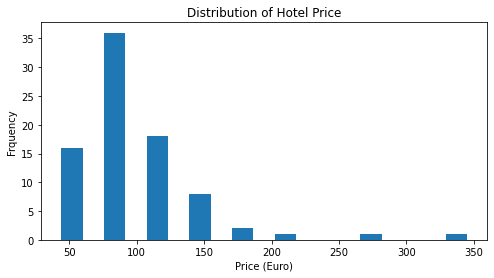

In [362]:
plt.figure(figsize=(8, 4))
plt.hist(df['price (euro)'], bins=10, rwidth=0.5)

plt.xlabel('Price (Euro)')
plt.ylabel('Frquency')
plt.title('Distribution of Hotel Price')

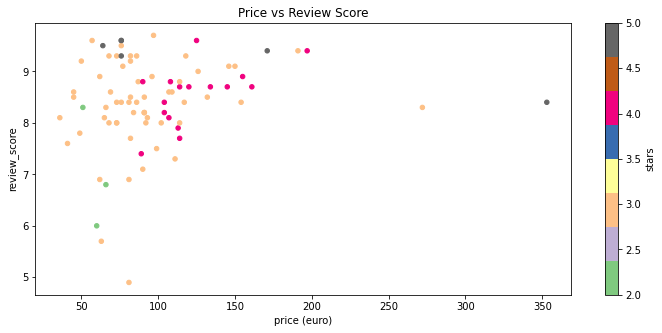

In [363]:
df.plot.scatter(x='price (euro)', y='review_score', c='stars', colormap='Accent', title = 'Price vs Review Score', figsize=(12, 5), sharex=False);

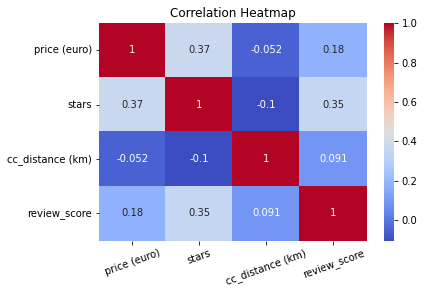

In [364]:
import seaborn as sns

temp_df = df[['price (euro)', 'stars', 'cc_distance (km)', 'review_score']]

hm = sns.heatmap(temp_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')
loc, labels = plt.xticks()

hm.set_xticklabels(labels, rotation=20)
hm.set_title('Correlation Heatmap');

# Step 4: Interaction with the user

In [367]:
import ipywidgets
from ipywidgets import FloatRangeSlider, Output, interact
from IPython.display import Image, HTML


price_min = df['price (euro)'].min()
price_max = df['price (euro)'].max()

price_widget = FloatRangeSlider(
    value=[price_min, price_max],
    min=price_min,
    max=price_max+1,
    step=1,
    description='Price range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

distance_min = df['cc_distance (km)'].min()
distance_max = df['cc_distance (km)'].max()

distance_widget = FloatRangeSlider(
    value=[distance_min, distance_max],
    min=distance_min,
    max=distance_max,
    step=0.1,
    description='Distance range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

stars_min = df['stars'].min() 
stars_max = df['stars'].max()

stars_widget = FloatRangeSlider(
    value=[stars_min, stars_max],
    min=stars_min,
    max=stars_max,
    step=1,
    description='Stars range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

review_score_min = df['review_score'].min()
review_score_max = df['review_score'].max()

review_score_widget = FloatRangeSlider(
    value=[review_score_min, review_score_max],
    min=review_score_min,
    max=review_score_max,
    step=0.1,
    description='Review score range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

In [383]:
@interact(price_range = price_widget)
def get_calorie_range(price_range):
    print(price_range)

@interact(distance_range = distance_widget)
def get_point_range(distance_range):
    print(distance_range)

@interact(stars_range = stars_widget)
def get_point_range(stars_range):
    print(stars_range)

@interact(review_score_range = review_score_widget)
def get_point_range(review_score_range):
    print(review_score_range)


print('\nSort By: ')
sort_by_list = ['Price', 'Distance', 'Stars', 'Review Score']
sort_by_picker = ipywidgets.Dropdown(options=sort_by_list, value='Price')
sort_by_picker

interactive(children=(FloatRangeSlider(value=(51.0, 287.0), continuous_update=False, description='Price range:…

interactive(children=(FloatRangeSlider(value=(3.6, 15.7), continuous_update=False, description='Distance range…

interactive(children=(FloatRangeSlider(value=(3.0, 5.0), continuous_update=False, description='Stars range:', …

interactive(children=(FloatRangeSlider(value=(6.2, 9.6), continuous_update=False, description='Review score ra…


Sort By: 


Dropdown(options=('Price', 'Distance', 'Stars', 'Review Score'), value='Price')

**After Selecting the value, Please run the next cell for output**

In [388]:
price_range_val = price_widget.value
distance_range_val = distance_widget.value
stars_range_val = stars_widget.value
review_score_range_val = review_score_widget.value
sort_by_val = sort_by_picker.value


df_filtered = df.loc[(df['price (euro)'] >= price_range_val[0]) &  (df['price (euro)'] <= price_range_val[1])
                        & (df['stars'] >= stars_range_val[0]) &  (df['stars'] <= stars_range_val[1])
                        & (df['cc_distance (km)'] >= distance_range_val[0]) &  (df['cc_distance (km)'] <= distance_range_val[1])
                        & (df['review_score'] >= review_score_range_val[0]) &  (df['review_score'] <= review_score_range_val[1])
                    ]

if sort_by_val == 'Price':
    df_filtered = df_filtered.sort_values(by=['price (euro)'])
elif sort_by_val == 'Distance':
    df_filtered = df_filtered.sort_values(by=['cc_distance (km))'])
elif sort_by_val == 'Stars':
    df_filtered = df_filtered.sort_values(by=['stars'], ascending=False)
elif sort_by_val == 'Review Score':
    df_filtered = df_filtered.sort_values(by=['review_score'], ascending=False)

df_filtered

,name,price (euro),stars,address,cc_distance (km),review_score,summary,photos_link,link
33,Meri,57.0,3.0,"Seiskarinkatu 35, Turku City Center, Turku, Fi...",3.4,9.6,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//meri-karina/hotel/all/t...
42,Omena Hotel Turku,62.0,3.0,"Humalistonkatu 7, Turku City Center, Turku, Fi...",0.2,6.9,Get your trip off to a great start with a stay...,[https://pix8.agoda.net/hotelImages/319/319458...,https://www.agoda.com//omena-hotel-turku/hotel...
65,3 bedrooms House with big hot tube.,62.0,3.0,"Turku City Center, Turku, Finland",3.3,8.9,Experience a perfect private villa stay here a...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//3-bedrooms-house-with-b...
61,Hotel Harriet,63.0,3.0,"11 Hantverkaregatan, Turku City Center, Turku,...",0.1,5.7,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//hotel-harriet_10/hotel/...
43,Turun Blanka A43,64.0,5.0,"Turku City Center, Turku, Finland",0.3,9.5,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//turun-blanka-a43/hotel/...
...,...,...,...,...,...,...,...,...,...
22,Riverside Lux with 2 bedrooms,171.0,5.0,"Turku City Center, Turku, Finland",1.0,9.4,Conveniently situated in the Turku City Center...,[https://q-xx.bstatic.com/xdata/images/hotel/8...,https://www.agoda.com//riverside-lux-with-2-be...
76,"Riverside Lux, Sauna, 2 underground car parking",191.0,3.0,None,1.8,9.4,This smoke-free apartment building features a ...,[https://www.kayak.co.uk/rimg/himg/d4/ff/8b/ex...,"https://www.kayak.co.uk//hotels/Riverside-Lux,..."
4,"Riverside Lux with 2 bedrooms, Car Park garage...",197.0,4.0,"Linnankatu 59 F, 20100 Turku, Finland",1.8,9.4,\n\nYou're eligible for a Genius discount at R...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/riverside-lux...
16,Apartment Turku City Center,272.0,3.0,"Uudenmaankatu 4 D72, 20500 Turku, Finland",0.6,8.3,\n\nYou're eligible for a Genius discount at A...,[https://t-cf.bstatic.com/xdata/images/hotel/m...,https://www.booking.com/hotel/fi/apartment-tur...


Please Run previous cell first then Select Hotel Name to get Details

In [395]:
available_hotel_name = list(df_filtered['name'])
hotel_picker = ipywidgets.Dropdown(options=available_hotel_name, value=available_hotel_name[0])
hotel_picker


Dropdown(options=('Meri', 'Omena Hotel Turku', '3 bedrooms House with big hot tube.', 'Hotel Harriet', 'Turun …

Please run the next cell to get details

Hotel name:	 Sunshine Apartment
Price:		 90.0  €
Distance:	 0.3 km
Stars:		 4.0
Review score:	 8.8
Adress:		 Turku City Center, Turku, Finland

Summary:	 Conveniently situated in the Turku City Center part of Turku, this property puts you close to attractions and interesting dining options. This 4-star property is packed with in-house facilities to improve the quality and joy of your stay.





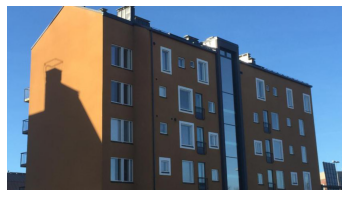

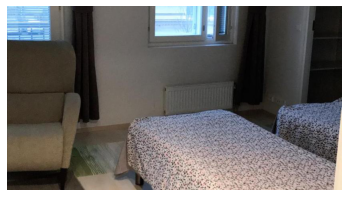

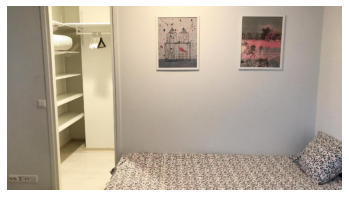

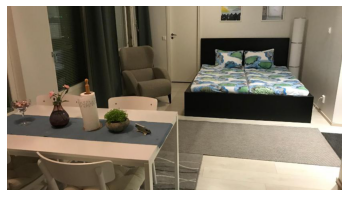

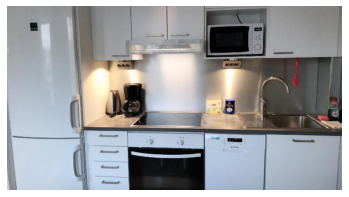

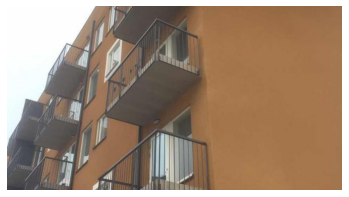

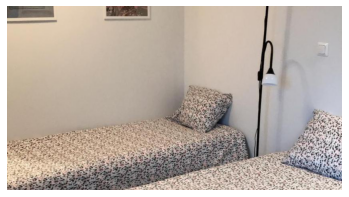

In [470]:
from PIL import Image
from io import BytesIO

df_hotel_detals = df_filtered.loc[df_filtered['name'] == hotel_picker.value]

print('Hotel name:\t', df_hotel_detals['name'].iloc[0])
print('Price:\t\t', df_hotel_detals['price (euro)'].iloc[0], ' €')
print('Distance:\t', df_hotel_detals['cc_distance (km)'].iloc[0], 'km')
print('Stars:\t\t', df_hotel_detals['stars'].iloc[0])
print('Review score:\t', df_hotel_detals['review_score'].iloc[0])
print('Adress:\t\t', df_hotel_detals['address'].iloc[0])
print('\nSummary:\t', df_hotel_detals['summary'].iloc[0])

print('\n\n')

photo_links = df_hotel_detals['photos_link'].iloc[0]
for photo_link in photo_links:
    plt.axis('off')
    img = Image.open(requests.get(photo_link, stream=True).raw)
    plt.imshow(img)
    plt.show()
    print('\n\n')